# Chemically speaking, what types of wine are there? What predicts wine quality?

****

Throughout this process I will largely be following the following data science workflow. Although this is the general process I will be following, it is key to note that this is an iterative process and I will likely retrospectively update sections as I learn more.

1. Identify the problem
2. Obtain the data
3. Explore the data
4. Prepare the data
5. Build a model
6. Conclusion

### 1. Identify the problem
****

**Objective**
Based on the information we have available in the data sets, I want to answer the following questions
1. What different types of wine are there from a chemical standpoint? 
2. What attributes are important in wine quality?

Why would this be useful?
By better understanding products, what causes variation in taste (quality) and where the similarities lie (type) in terms of chemical composition, an organisation is better equipped to:
- Market their products better
- Understand their customer segments and what they value in their wine
- Differentiate their products from competitors
- Improve and refine their products

### 2. Obtain the data
****

In this section I read in the datasets  and read in the imports and packages that I plan on using throughout the notebook. As the datasets are in .csv format. I will read them directly into a pandas dataframe for ease of manipulation and exploration.


#### Imports and packages

In [66]:
# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

# Machine Learning packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix

#Misc
from itertools import product

#### Setup helper functions

In [2]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    #facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.set( xlim=( 0 , 150 ) )
    facet.add_legend()
    facet.set_axis_labels(var, 'Probability Density')

#### Reading in the datasets

The datasets and accompanying readme I will be working with can be found here - http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/

In [3]:
white_wine_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
red_wine_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

white_df = pd.read_csv(white_wine_url, sep=';')
red_df = pd.read_csv(red_wine_url, sep=';') 

### 3. Explore the data
****
The focus of this section is exploratory data analysis (EDA), I aim to really understand the data i'm working with. I make use of the Pandas library to clean, manipulate and inspect the data i'm working with. I also make use of Matplotlib and Seaborn to visualise how the data is distributed.

Given I know that the same data exists in both data sets, I am adding an attribute to each wine dataframe and then concatenating the dataframes to form a single one.

In [4]:
# Adding a new attribute to each data set so this information is not lost when we join them.
red_df['colour'] = 'r'
white_df['colour'] = 'w'

#Joining the datasets
df = pd.concat([red_df, white_df], axis=0, ignore_index=True) 

Let's look at the combined wines dataframe: df

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,colour
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,r
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,r
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,r
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,r
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,r


Quick note: you'll notice that all attributes of the win are objective except for one, 'quality'. The 'quality' attribute is based on sensory data. It is the result of the median of at least 3 evaluations made by wine experts. Each graded the wine quality between 0 (very bad) and 10 (very excellent).

**What type of machine learning problem is this?**
At this point it makes sense to re-visit the problem in the context of machine learning. 

Obj1: What different types of wine are there from a chemical standpoint?
This appears to be an **unsupervised** problem as we don't have any data on the types of wine we will be working with(apart from red and white). As we are dealing with **continuous data**, this will likely be a **clustering problem**, where we will attempt to group wines based on their attributes.

Obj2: What attributes are important in wine quality?
This looks like it will be a **supervised** problem as we have labelled training data. Additionally, we will be trying to predict data that can be treated as **continuous** (quality) so at this point, we can theorize that this will be a **regression problem**.

We have 6497 rows and 13 columns.

In [6]:
df.shape

(6497, 13)

What data types are we dealing with?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
colour                  6497 non-null object
dtypes: float64(11), int64(1), object(1)
memory usage: 659.9+ KB


We have zero null entries, and all values are floats except for quality (which is an integer) and colour (an object). Given we are largely dealing with numeric data, I am pulling up summary statistics to see if there are any red flags in the distribution for each element.

In [8]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


We can see that for residual sugar the mean is significantly greater than the median (50%) impying a positively skewed distribution.

#### Visualising the data

Below I have produced a heatmap which calculates the standard correlation coefficient for each of our relationships - r.

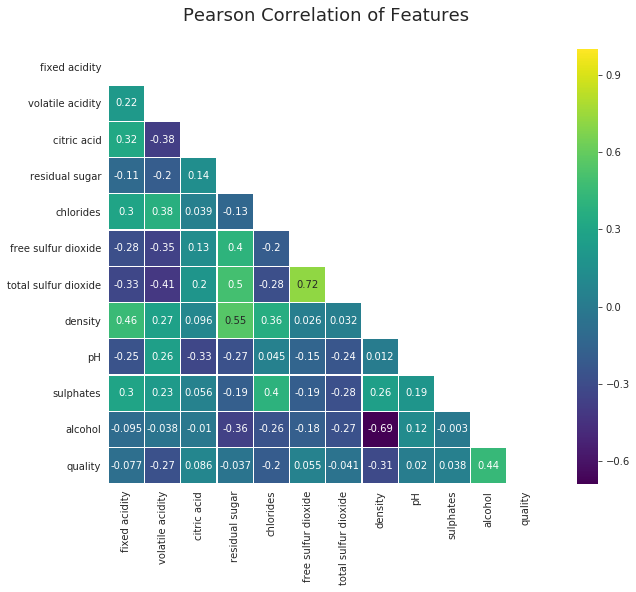

In [9]:
corr = df.drop('colour', 1).astype(float).corr()
plt.figure(figsize=(12,8))
plt.title('Pearson Correlation of Features', y=1.05, size=18)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    corr,
    linewidths=0.1,
    mask=mask, 
    vmax=1.0, 
    square=True, 
    cmap=plt.cm.viridis, 
    linecolor='white', 
    annot=True
)
plt.show()

Clearly we can see from the above that we have a lot of interesting relationships.
- Alcohol seems to be strongly correlated to quality.
- Density and volatile acidity are inversely correlated to quality. (Yet alcohol and density are inversely correlated).
- Residual sugar is strongly correlated with density, chlorides and fixed acidity.

When key predictor variables are correlated with each other, this can sometimes prevent the effectiveness in calculating the coefficient of determination, when used together in a multiple regression. (CHECK)

Some attributes are expectedly strongly correlated (anecdotally, one would expect that they would be dependent on each other)
- The attributes around acidity (volatile acidity, citric acid, fixed acidity)
- The attributes around sulfur dioxide (free sulfur dioxide, total sulfur dioxide)


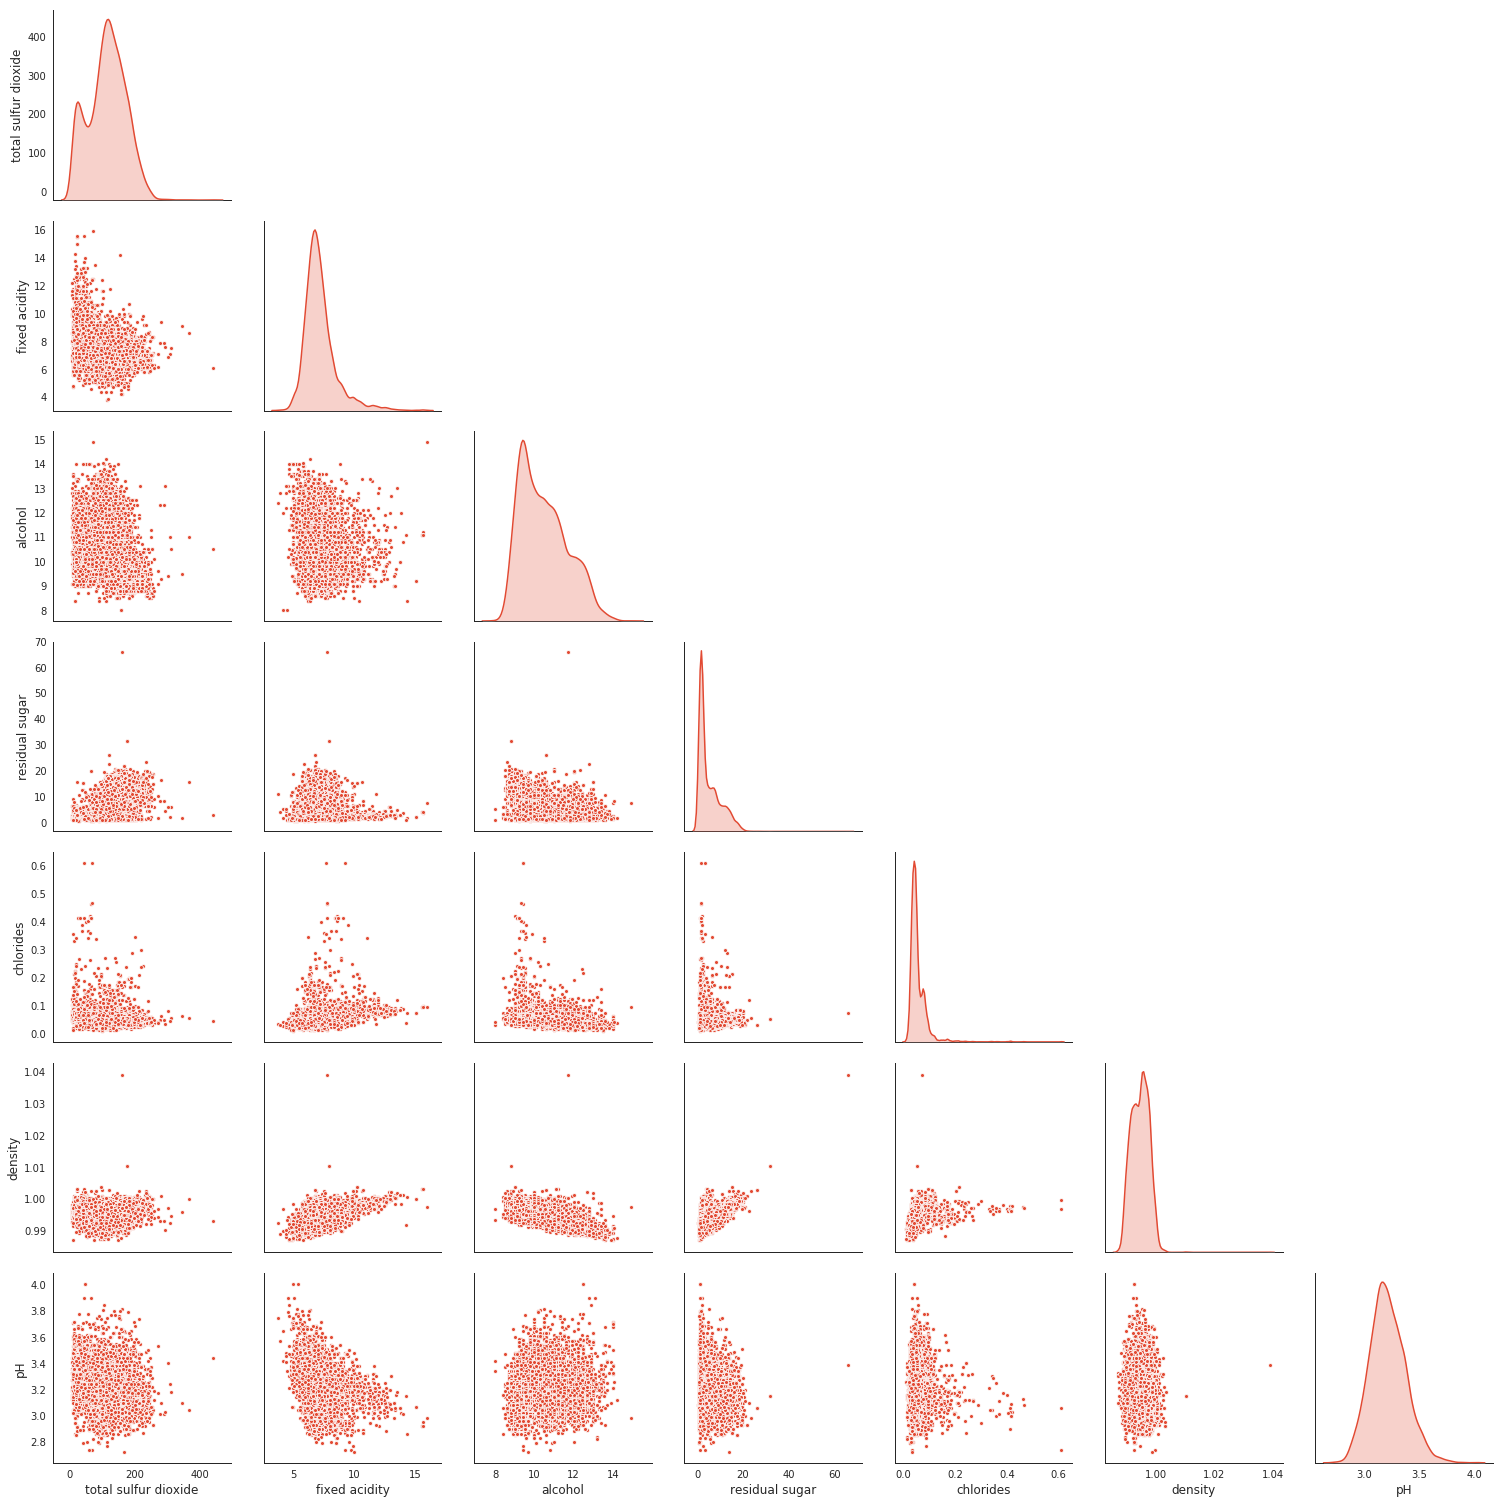

In [11]:
#This produces a number of plots with variables paired up. This should hopefully give me an indication of how easy
# it will be to decide whether a person would have survived or not based on the data we have available to us.
pair_plot = sns.pairplot(df,
            #hue= 'qcat', # The target, the variable we are trying to see separation for.
            vars= ['total sulfur dioxide', 'fixed acidity','alcohol', 'residual sugar', 
                   'chlorides', 'density', 'pH'], # The variables we are working with
            height=3, #size of each plot
            diag_kind='kde', #Kind of plot for the diagonal subplots
            plot_kws={"s": 15, "alpha":1}
            
            )

#The below code hides the top right triangle of plots (which is a mirror of the bottom left)
for i, j in zip(*np.triu_indices_from(pair_plot.axes, 1)):
    pair_plot.axes[i, j].set_visible(False)

In [12]:
df.describe().loc[['mean','50%']]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000


##### Delving deeper into quality

Here we we will take a closer look at quality and how it relates to other variables. Looking at these relationships from several different angles should aid in our decision making in building a robust regression algorithm.

FIGURE OUT HOW TO PLOT THE BEST FIT LINE WITH THESE SCATTER DIAGRAMS

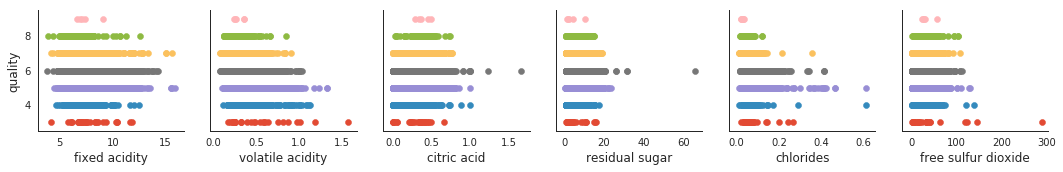

In [13]:
g = sns.PairGrid(df, hue='quality', y_vars='quality', 
                 x_vars = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide'])
g.map(plt.scatter)


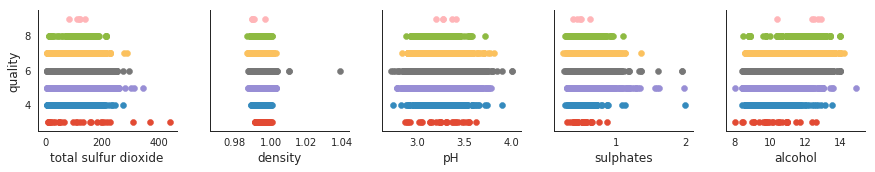

In [14]:
g = sns.PairGrid(df, hue='quality', y_vars='quality', 
                 x_vars = [ 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
g.map(plt.scatter)

The sets of graphs aboves are scatter plots of quality against other variables. For the large part, we can see that it is quite difficult to discern how quality is related to these other variables. Saying that, one could make a case for the following trends.

- A negative trend between volatile acidity/ chlorides/ sulphates and quality.
- A positive trend between alcohol and quality.

Some of these trends agree with what we saw from the correlation heatmap, others such as sulphates do not.

### Prepare the data

#### Feature Scaling

When data is heavily positively skewed it sometimes makes sense to use logarithmic scaling. In order to do this we need to remove the zeros as the natural log of 0 is -infinity. Here I replace all the zero's with 0.001. We can see from the description table, that this has only updated values for citric acid.

In [17]:
def remove_zeros(value):
    if value == 0:
        value = .001
    return value

no_zero_df = df.applymap(remove_zeros)
no_zero_df.describe().loc[['min']]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
min,3.8,0.08,0.001,0.6,0.009,1.0,6.0,0.98711,2.72,0.22,8.0,3.0


Below I apply logarthmic scaling.

In [18]:
# Scale the data using the natural logarithm
#quant_df = no_zero_df.drop(['qcat','colour'],axis=1)
log_df = no_zero_df.drop(['colour'],axis=1).applymap(np.log)

# Scale the sample data using the natural logarithm
#log_samples = samples.applymap(np.log)

log_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,1.962001,-1.180294,-1.380901,1.325705,-2.990625,3.216126,4.563833,-0.005322,1.167679,-0.666818,2.344317,1.749540
std,0.164255,0.439046,1.045057,0.863555,0.431162,0.698635,0.714447,0.003012,0.049641,0.257057,0.111313,0.152891
min,1.335001,-2.525729,-6.907755,-0.510826,-4.710531,0.000000,1.791759,-0.012974,1.000632,-1.514128,2.079442,1.098612
25%,1.856298,-1.469676,-1.386294,0.587787,-3.270169,2.833213,4.343805,-0.007689,1.134623,-0.843970,2.251292,1.609438
50%,1.945910,-1.237874,-1.171183,1.098612,-3.057608,3.367296,4.770685,-0.005123,1.166271,-0.673345,2.332144,1.791759
75%,2.041220,-0.916291,-0.941609,2.091864,-2.733368,3.713572,5.049856,-0.003015,1.199965,-0.510826,2.424803,1.791759
max,2.766319,0.457425,0.506818,4.186620,-0.492658,5.666427,6.086775,0.038239,1.388791,0.693147,2.701361,2.197225


#### Feature scaling

When data is heavily positively skewed it sometimes makes sense to use logarithmic scaling. In order to do this we need to remove the zeros as the natural log of 0 is -infinity. Here I replace all the zero's with 0.001. We can see from the description table, that this has only updated values for citric acid.

In [19]:
def remove_zeros(value):
    if value == 0:
        value = .001
    return value

no_zero_df = df.applymap(remove_zeros)
no_zero_df.describe().loc[['min']]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
min,3.8,0.08,0.001,0.6,0.009,1.0,6.0,0.98711,2.72,0.22,8.0,3.0


In [20]:
log_df = no_zero_df.drop(['colour'],axis=1).applymap(np.log)

In [21]:
scaler = StandardScaler()

In [22]:
#quant_df = log_df.drop(['colour'],axis=1)
#df_col = df['colour']

In [23]:
X = scaler.fit_transform(log_df)
dfx = pd.DataFrame(data=X,columns=df.columns[:-1])
scaled_df = dfx
dfx.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.240369,1.876072,-5.288973,-0.791963,0.959347,-1.171275,-1.452245,1.035635,1.771578,0.338472,-0.930853,-0.916425
1,0.560894,2.397336,-5.288973,-0.428719,1.549041,0.003936,-0.502721,0.702758,-0.091226,1.093834,-0.556448,-0.916425
2,0.560894,2.063397,-1.758867,-0.570703,1.402498,-0.727296,-0.804668,0.769360,0.283014,0.918293,-0.556448,-0.916425
3,2.763674,-0.211092,0.766603,-0.791963,0.928625,-0.548129,-0.657186,1.102170,-0.344638,0.474994,-0.556448,0.276163
4,0.240369,1.876072,-5.288973,-0.791963,0.959347,-1.171275,-1.452245,1.035635,1.771578,0.338472,-0.930853,-0.916425


### 5a. Building the Model (Part 1 Clustering)
****

#### Data preprocessing
****
Mostly from - https://github.com/jeremyjordan/customer-segmentation/blob/master/customer_segments.ipynb

#### Finding the optimum number of clusters

Here we use the silhouette score function to find the optimal number of clusters to use to segment the data.

In [24]:
# Use silhouette score to find optimal number of clusters to segment the data
def optimum_clusters(data):
    num_clusters = np.arange(2,10)
    results = {}
    for size in num_clusters:
        model = KMeans(n_clusters = size).fit(data)
        predictions = model.predict(data)
        results[size] = silhouette_score(data, predictions)

    best_size = max(results, key=results.get)
    
    return best_size


num_clust = optimum_clusters(dfx)


In [25]:
print(num_clust)

2


The silhouette_score tells us that the optimum number of clusters for this is 2. At this point we can theorize that the two clusters will be red and white.

#### Clustering

Here we fit a KMeans clustering algorithm to all the data and ask it to produce two clusters. We are going to initialise the cluster 10 times to reduce the risk of local minima. Next we use the predict function to return cluster labels for each of the data points (i.e. whether it belongs to cluster 1 or 2)

In [51]:
clust = KMeans(n_clusters=2, n_init=10, max_iter=300)
clust.fit(scaled_df)

clust_labels = clust.predict(scaled_df)
clus_cent = clust.cluster_centers_
clust_labels_df = pd.DataFrame(clust_labels)

#### Visualising the clusters

To visualise the clusters we want to use PCA.

#### Dimension reduction

In [52]:
pca = PCA(n_components=None)
prin_comp = pca.fit(dfx)

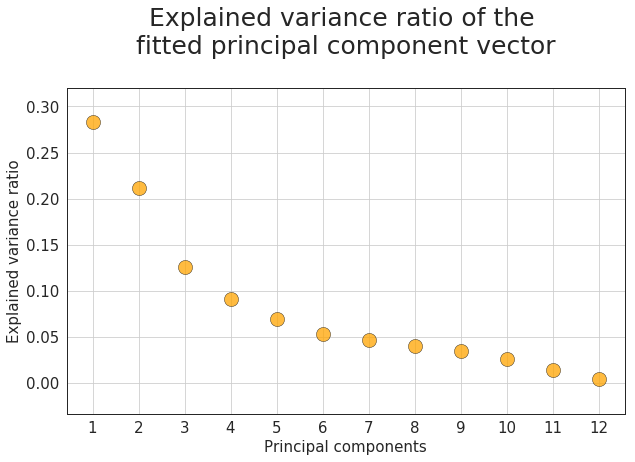

In [53]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(prin_comp.explained_variance_ratio_))],
            y=prin_comp.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(prin_comp.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

The above plot means that the $1^{st}$ principal component explains about 28% of the total variance in the data and the $2^{nd}$ component explians a further 21% and the third explains 13%. Therefore, if we just consider first three components, they together explain 62% of the total variance.

#### Transform the scaled data set using the fitted PCA object

In [54]:
pc_df = pca.transform(scaled_df)
pc_df = pd.DataFrame(data=pc_df)
pc_df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11
0,4.411944,-0.870042,3.722496,0.524619,1.283256,0.260237,-1.623102,1.198343,-1.484345,0.151303,0.495418,0.005988
1,3.829504,0.006231,3.046850,0.504605,1.400404,2.554750,-1.884133,1.426637,-0.928559,0.545012,0.532557,-0.014215
2,3.325618,0.201200,1.125063,0.341589,0.201555,1.063489,-0.271588,0.131480,-0.030232,-0.169621,0.152037,0.039708
3,1.907332,0.957722,-2.373429,-0.158827,-0.422383,-0.187392,-0.542733,-0.453023,-1.213208,-0.085151,0.174357,-0.026914
4,4.411944,-0.870042,3.722496,0.524619,1.283256,0.260237,-1.623102,1.198343,-1.484345,0.151303,0.495418,0.005988


For the purposes of visualisation we will be taking the three principle components that have the highest explained variance ratio.

Text(0.5, 0, 'Principle Component 3')

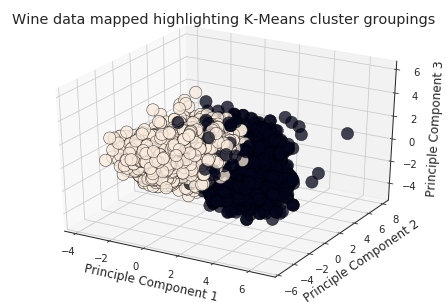

In [55]:

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(pc_df[0],pc_df[1],pc_df[2],
           c=clust_labels_df[0],edgecolors='k',alpha=0.75,s=150)
ax.set_title('Wine data mapped highlighting K-Means cluster groupings')
ax.set_xlabel('Principle Component 1')
ax.set_ylabel('Principle Component 2')
ax.set_zlabel('Principle Component 3')

Earlier in this study, when we used silhouette scoring to optimise the number of clusters (at 2) - we hypothesised the possibility that the two clusters could inadvertantly give us the same labels as we might perhaps expect if we were targeting colour separation - red and white. 

If this was the case, I would expect a plot with the same dimensions to look similar in their marker colours.

In [31]:
help(ax.scatter)

Help on method scatter in module mpl_toolkits.mplot3d.axes3d:

scatter(xs, ys, zs=0, zdir='z', s=20, c=None, depthshade=True, *args, **kwargs) method of mpl_toolkits.mplot3d.axes3d.Axes3D instance
    Create a scatter plot.
    
    ============  ========================================================
    Argument      Description
    ============  ========================================================
    *xs*, *ys*    Positions of data points.
    *zs*          Either an array of the same length as *xs* and
                  *ys* or a single value to place all points in
                  the same plane. Default is 0.
    *zdir*        Which direction to use as z ('x', 'y' or 'z')
                  when plotting a 2D set.
    *s*           Size in points^2.  It is a scalar or an array of the
                  same length as *x* and *y*.
    
    *c*           A color. *c* can be a single color format string, or a
                  sequence of color specifications of length *N*, or 

Text(0.5, 0, 'Principle Component 3')

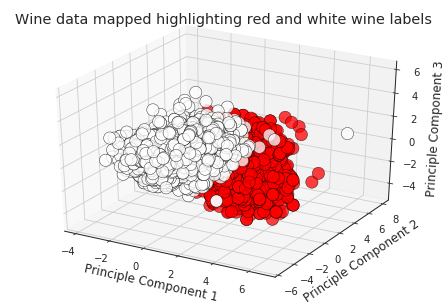

In [56]:

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(pc_df[0],pc_df[1],pc_df[2],c=df['colour'],edgecolors='k',alpha=0.75,s=150)
ax.set_title('Wine data mapped highlighting red and white wine labels')
ax.set_xlabel('Principle Component 1')
ax.set_ylabel('Principle Component 2')
ax.set_zlabel('Principle Component 3')

We can see above that we were not far off with this coloured wine hypothesis. However, it's difficult to see how close we are to actually predicting the colour with a clustering method. To investigate this further, I create a confusion matrix below and calculate the accuracy as I would if we were working with a supervised learning algorithm.

In order to do this, below I carry out the following steps:
1. Convert the wine colours to 0s and 1s.
2. Add (and adjust if necessary) our cluster labels to the original dataframe to see how they line up (i.e. whether a red would relate to cluster 0 or 1)

In [62]:
def binarise_colour(df):
    for index, row in df.iterrows():
        if row['colour'] == 'w':
            value = 1
        if row['colour'] == 'r':
            value = 0
        df.loc[index, 'colour val'] = value
    return None

binarise_colour(df)

Adding the cluster labels to the data frame.

In [64]:
clust_labels_df.rename(columns={0:'cluster label'}, inplace=True)
#del df['cluster label']
df = df.join(clust_labels_df, how='right')
df.loc[1594:1602]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,colour,colour val,cluster label
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,r,0.0,0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,r,0.0,0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,r,0.0,0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,r,0.0,0
1598,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6,r,0.0,0
1599,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,w,1.0,1
1600,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,w,1.0,1
1601,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,w,1.0,1
1602,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,w,1.0,1


We can see that the zeros and ones line up. Now let's visualise how we have done using a confusion matrix.

In [35]:
clust_labels_arr = clust_labels_df.values
colours_arr = df['colour val'].values

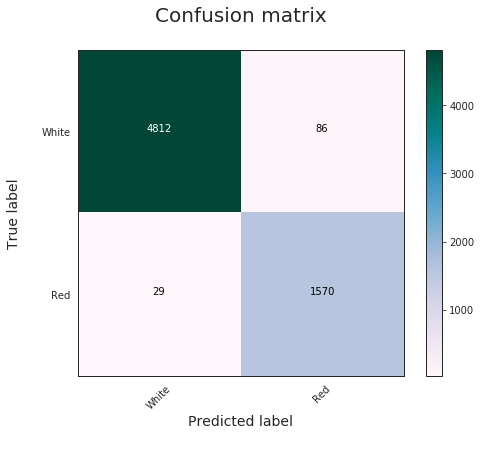

In [69]:


def plot_confusion_matrix(cm, classes, title='Confusion matrix\n', cmap=plt.cm.PuBuGn):
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label\n', fontsize=14)
    plt.xlabel('Predicted label\n', fontsize=14)
    plt.show()

conmat = confusion_matrix(colours_arr, clust_labels_arr)
plot_confusion_matrix(conmat, ["White", "Red"])

The results look promsing, to confirm how well the clustering algorithm has modelled red and white wine, I calculate the accuracy below.

In [37]:
from sklearn import metrics
metrics.accuracy_score(colours_arr, clust_labels_arr)

0.9822995228567031

98%, I would argue that is pretty conclusive, there are clearly different types of wine from a chemical standpoint and those differences appear to aggregate in two known types of wine - red and white. Who knew? 

### 5b. Building the Model (Part 2 Regression)
****

- We know our data contains categoric data so we should convert these values to quantitative information that the regression model can interpret.
- Then we split our data into training and testing sets.
- Fit the algorithm.
- Predict the target.
- Measure how we did.


In [38]:
#Removing the columns that were added as part of clustering as they have no value in the regression.

del df['cluster label']
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,colour,colour val
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,r,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,r,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,r,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,r,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,r,1.0


Given alcohol had a strong correlation with wine quality, it makes sense to train our regression algorithm with this feature initially. First, we'll build a basic linear regression with a single feature input as a baseline for the model to beat.

In [79]:
def linear_reg(df, feature):
    feat_score = {}
    X = df[feature].values.reshape(-1, 1)
    y = df['quality'].values.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    reg = LinearRegression()
    reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)

    feat_score[feature] = reg.score(X_test, y_test)
    
    return feat_score, X_test, y_pred, X, y

r-squared score:  0.19217354646527984


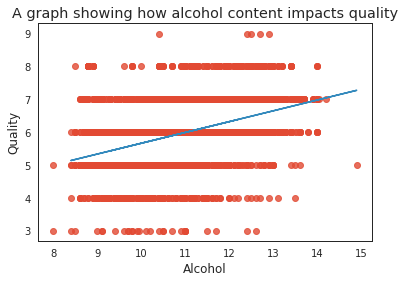

In [40]:
feat_score, X_test, y_pred, X, y = linear_reg('alcohol')

print ("r-squared score: ", feat_score['alcohol'])

sns.regplot(x=X, y=y, fit_reg=False)
plt.plot(X_test, y_pred)
plt.title('A graph showing how alcohol content impacts quality')
plt.xlabel('Alcohol')
plt.ylabel('Quality')
plt.show()

As expected the r-squared score for alcohol is 0.19. Our correlation heatmap earlier calculated Pearson's r as 0.44. If we were to square 0.44, we would achieve 0.19 - showing our model is working as intended. 

#### Assess effect of multiple varibles

Here, I run a linear regression on multiple variables to assess their affect on the coefficient of determination. These are the variables which were found to have a significant relationship in the exploratory data analysis carried out in seciton 3. 

In [41]:
feat_scores = {}
X = df[['alcohol', 'volatile acidity', 'chlorides', 'colour val']]  
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print('r-squared score: \n', reg.score(X_test, y_test))
print('Const: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

r-squared score: 
 0.26140337954965254
Const: 
 3.0179587449506577
Coefficients: 
 [ 0.31959091 -1.70081233 -0.53883163  0.22240976]


Note that density was initially added as a term in the multiple regression above. It was subsequently removed after it was shown to reduce the r^2 coefficient. This phenomena can be explained by the strong negative correlation between alcohol and density shown in the correlation map (-0.69) - i.e. alcohol and density are highly correlated.

#### Assess effect of polynomial modelling

Although the exploratory data analysis didn't appear to show a polynomial relationship, the below code was written in attempt to improve the coefficient of determination. For every variable we work out the coefficient of determination. 

In [42]:
features = list(df.columns)
features.remove('colour') #qualitative data which has been converted to colour val
features.remove('quality') #target variable
print(features)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'colour val']


In [81]:
def loop_regression(df, features, order):
    feat_scores = {}
    for feature in features:
        if order == 1:
            feat_scores[feature] = linear_reg(df, feature)[0].get(feature)
        else:
            feat_scores[feature] = poly_reg(df, feature, order).get(feature)
        

    return feat_scores

In [74]:
def poly_reg(df, feature, order):
    feat_scorez = {}
    X = df[feature].values.reshape(-1, 1)
    y = df['quality'].values.reshape(-1, 1)
    
    # create a Linear Regressor   
    lin_regressor = LinearRegression()

    # pass the order of your polynomial here  
    poly = PolynomialFeatures(order)

    # convert to be used further to linear regression
    X_transform = poly.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_transform, y, test_size=0.3, random_state=42)

    # fit this to Linear Regressor
    lin_regressor.fit(X_train,y_train) 

    # get the predictions
    y_preds = lin_regressor.predict(X_test)

    #print ("r-squared score: ", lin_regressor.score(X_test, y_test))
    feat_scores[feature] = lin_regressor.score(X_test, y_test)
    return feat_scores
    

In [45]:
feat_scores_1 = loop_regression(features, 1)
feat_scores_2 = loop_regression(features, 2)
feat_scores_3 = loop_regression(features, 3)

order_scores = pd.DataFrame({'1st Order':pd.Series(feat_scores_1),
                             '2nd Order':pd.Series(feat_scores_2),
                             '3rd Order':pd.Series(feat_scores_3)})
order_scores

,1st Order,2nd Order,3rd Order
fixed acidity,0.009534,0.015424,0.016047
volatile acidity,0.070765,0.070877,0.071050
citric acid,0.005965,0.009319,0.028397
residual sugar,0.002331,0.002707,0.006054
chlorides,0.046909,0.055145,0.064033
free sulfur dioxide,0.001312,-0.112257,-0.284547
total sulfur dioxide,0.001534,0.033594,0.033033
density,0.105621,0.116499,0.128148
pH,0.000697,0.002092,0.002371
sulphates,0.000296,-0.000066,0.011053


The above table shows how the coefficient of determination varies when the data is modelled using different order polynomials. As we can see, the effect is insignificant. As such I see no reason to further investigate. 

#### Assess affect of splitting the data sets out
Here I will see if we can improve quality by splitting the data sets into red and white sets.

In [72]:
del red_df['colour']
red_df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [83]:
features.remove('colour val')

{'fixed acidity': 0.023713227973223727,
 'volatile acidity': 0.16265613189785655,
 'citric acid': 0.0752640555152464,
 'residual sugar': -0.003088386707527091,
 'chlorides': 0.011841973638719305,
 'free sulfur dioxide': -0.002831364187794616,
 'total sulfur dioxide': 0.014828669918919068,
 'density': 0.014130453831202374,
 'pH': 0.003062801329370979,
 'sulphates': 0.06939048849039153,
 'alcohol': 0.18535810854277013}

For each feature, what does a single linear regression yield?

In [84]:
red_feat_scores_1 = loop_regression(red_df, features, 1)
red_feat_scores_1

{'fixed acidity': 0.023713227973223727,
 'volatile acidity': 0.16265613189785655,
 'citric acid': 0.0752640555152464,
 'residual sugar': -0.003088386707527091,
 'chlorides': 0.011841973638719305,
 'free sulfur dioxide': -0.002831364187794616,
 'total sulfur dioxide': 0.014828669918919068,
 'density': 0.014130453831202374,
 'pH': 0.003062801329370979,
 'sulphates': 0.06939048849039153,
 'alcohol': 0.18535810854277013}

In [85]:
white_feat_scores_1 = loop_regression(white_df, features, 1)
white_feat_scores_1

{'fixed acidity': 0.007993483067511353,
 'volatile acidity': 0.026999654494167746,
 'citric acid': -0.0025057276566817777,
 'residual sugar': 0.009372835532209467,
 'chlorides': 0.060079171045755664,
 'free sulfur dioxide': -0.003397856567868951,
 'total sulfur dioxide': 0.03943603457412348,
 'density': 0.10324371759946893,
 'pH': 0.0036520918050411133,
 'sulphates': -0.0012132613287343386,
 'alcohol': 0.19317977701698663}

As we can see, there is only a marginal improvement by splitting the data set.

### 6 Conclusion
****

**What different types of wine are there from a chemical standpoint?**

Through this study it can be seen that there are chemically very different types of wine, these coincide with the two types of wine that were involved in the data set.

**What attributes are important in wine quality?**

Although we were able to find some predicting factors in wine quality such as alcohol. We were only able to explain 27% of the variation. 